# Make the board and report images based on saved data

Data is saved in `5 - Depth Calculation OFD.ipynb` using the `grabframe` parameter

1. Load the `frame_results.p` file
1. process and make the figures

In [1]:
# set the to get the correct path 
user = 'marcvanzyl'
user = 'gerrie'

In [2]:
import numpy as np
import cv2, os
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
%matplotlib inline

In [3]:
import pandas as pd

# Load the list of files

In [4]:
datadir = "/Users/{}/Google Drive/ScienceFair2021/DataCapture/smooth/".format(user)


video_files = np.array([f for f in os.listdir(datadir) if f.endswith(".mp4") ])

# just sorts the files
video_files.sort()

In [5]:
video_files

array(['Smooth_15_-2_0_4623HF.mp4', 'Smooth_15_-2_1_QV4WNZ.mp4',
       'Smooth_15_-2_2_JB90U4.mp4', 'Smooth_15_-2_3_MCDNNA.mp4',
       'Smooth_15_-2_4_VIWO2O.mp4', 'Smooth_15_-4_0_ESS22N.mp4',
       'Smooth_15_-4_1_8GD6QO.mp4', 'Smooth_15_-4_2_FMBNMX.mp4',
       'Smooth_15_-4_3_EEUONU.mp4', 'Smooth_15_-4_4_64CXH3.mp4',
       'Smooth_15_-6_0_2HDNNZ.mp4', 'Smooth_15_-6_1_D23FV7.mp4',
       'Smooth_15_-6_2_U8BJY4.mp4', 'Smooth_15_-6_3_GK86VH.mp4',
       'Smooth_15_-6_4_JU8DFH.mp4', 'Smooth_15_0_0_D26LA1.mp4',
       'Smooth_15_0_1_OOBKBZ.mp4', 'Smooth_15_0_2_MNBSLT.mp4',
       'Smooth_15_0_3_VY12DF.mp4', 'Smooth_15_0_4_46CIDO.mp4',
       'Smooth_30_-2_0_07HKRJ.mp4', 'Smooth_30_-2_1_UA678T.mp4',
       'Smooth_30_-2_2_Z2CEPT.mp4', 'Smooth_30_-2_3_DPNF63.mp4',
       'Smooth_30_-2_4_O2G6SZ.mp4', 'Smooth_30_-4_0_9WKFQF.mp4',
       'Smooth_30_-4_1_B6QVWT.mp4', 'Smooth_30_-4_2_9YG7KZ.mp4',
       'Smooth_30_-4_3_ZZ3YEH.mp4', 'Smooth_30_-4_4_ARXESZ.mp4',
       'Smooth_30_-6_0_HOA2A3.

# Camera properties
These are used to convert pixel displacement to distances

## Camera features:
- sensor size = 3.68 x 2.76 mm  
- sensor resolution  = 3280 × 2464
- focal length = 3.04 mm

$$ d_{mm} = \frac{pix \times 3.68}{3280} $$

The depth can now be found
$$ Z = \frac{T \times f}{d_{mm}} $$

In [6]:
# number of pixel/frame displacemet per degree/s of rotation
rotational_coeff = 2.05661689

# camera frames per second
camera_fps = 21

In [7]:
# Actual distances
actual_dist = pd.Series([1550,1560,2020,2030,2575,2580], index=['OFZ0','OFZ1','OFZ2','OFZ3','OFZ4','OFZ5'], name='Actual Distance [mm]')

# convert to a dataframe
actual_df = pd.DataFrame(actual_dist)
actual_df.index.name = 'Zone'
actual_df

,Actual Distance [mm]
Zone,
OFZ0,1550
OFZ1,1560
OFZ2,2020
OFZ3,2030
OFZ4,2575
OFZ5,2580


In [8]:
# calculate the movement of the camera each frame
def calc_camera_translation(v, frame_rate):
    return v/frame_rate

# calculate the distance using the optical flow pixel displacement
def calc_depth(pix, step):
    
    sensor_x = 3.68
    f = 3.04
    sensor_x_res = 3280
    
    d_mm = pix*sensor_x/sensor_x_res
    
    return step*f/d_mm

# Load the results file

In [9]:
results = pickle.load(open('{}full_analysis_results.p'.format(datadir), 'rb'))

In [10]:
results

{'15.0_-2.0':          n    Raw Flow Linear Flow Distance Actual Dist Frame Error  \
 Zone       [pix/frame] [pix/frame]     [mm]        [mm]        [mm]   
 OFZ0  1347       5.861       1.333   1480.8        1550       -69.2   
 OFZ1  1400       5.569       1.279   1543.6        1560       -16.4   
 OFZ2  1370       5.650       1.034   1908.7        2020      -111.3   
 OFZ3  1389       5.458       0.998   1978.2        2030       -51.8   
 OFZ4  1360       5.581       0.855   2307.5        2575      -267.5   
 OFZ5  1383       5.378       0.836   2360.3        2580      -219.7   
 
      Frame StdDev Rolling Window Error Rolling Window Error %  \
 Zone         [mm]                 [mm]                    [%]   
 OFZ0        402.3                 9.88                   0.64   
 OFZ1        422.4                 0.46                   0.03   
 OFZ2        687.0               -19.72                  -0.98   
 OFZ3        714.8               -26.64                  -1.31   
 OFZ4       1

In [10]:
# extract the data
img = results['img']
filename = results['filename']
frame = results['frame']
flow = results['flow']
centers = results['centers']
center_ids = results['center_ids']
frame_res = results['frame_res']


KeyError: 'img'

In [12]:
results.keys()

dict_keys(['15.0_-2.0', '15.0_-4.0', '15.0_-6.0', '15.0_0.0', '30.0_-2.0', '30.0_-4.0', '30.0_-6.0', '30.0_0.0', '45.0_-2.0', '45.0_-4.0', '45.0_-6.0', '45.0_0.0', '60.0_-2.0', '60.0_-4.0', '60.0_-6.0', '60.0_0.0'])

In [13]:
# parameters to calculate distance
rot_vel = 0
lin_vel = 60

In [14]:
# create bgr image from grayscale
alpha = np.ones_like(img)*80  # create the alpha channel
img_3gray = cv2.merge((img,img,img,alpha)) # create gray bgr image

hsv = cv2.cvtColor(img_3gray, cv2.COLOR_BGR2HSV)

NameError: name 'img' is not defined

In [13]:
mag = (cv2.multiply(cv2.add(flow[...,0],-10),5))

mag[mag<0.0] = 0
mag[mag>255] = 255



In [14]:
flow_x = flow[...,0]  # extract the x flow

dist = calc_depth((flow_x/2.2 + 1.05*rotational_coeff*rot_vel), calc_camera_translation(lin_vel, camera_fps))

dist[dist<500] = 0
dist[dist>3000] = 0

In [15]:
# remove all the points with less than 100mm distance (elminiate the zeroes)
dist_hist = dist[dist>100]

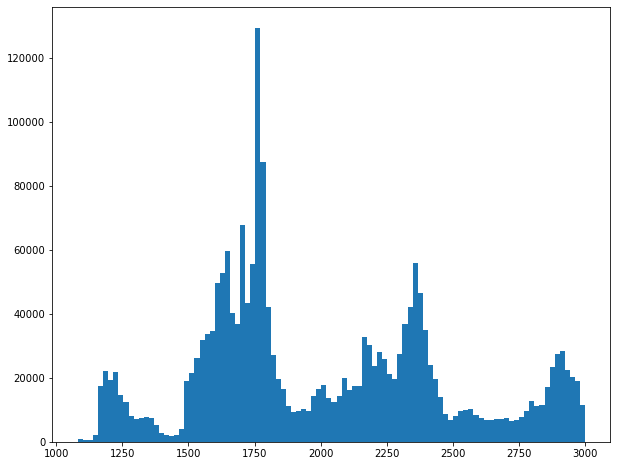

In [16]:
# plot the distance distribution
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(dist_hist.reshape(1,-1)[0], bins=100)
plt.show()

In [17]:

dist[dist>2900] = 2900 # This an adjustment to clip the exremities in this particular file

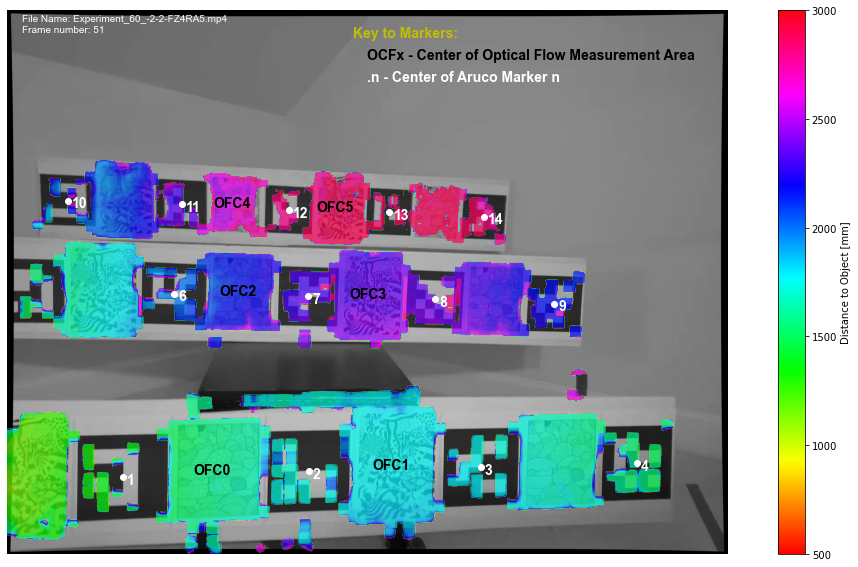

In [18]:
fig, ax = plt.subplots(figsize=(18,10))



# create bgr image from grayscale
alpha = np.ones_like(img)*80  # create the alpha channel
alpha[dist<300] = 255   # remove transparency where there is no flow information


img_3gray = cv2.merge((img,img,img,alpha)) # create gray bgr image
hsv = cv2.cvtColor(img_3gray, cv2.COLOR_BGR2HSV)

pos = ax.imshow(dist, vmin=500., vmax=3000,cmap='hsv')
fig.colorbar(pos, ax=ax, label="Distance to Object [mm]")
ax.imshow(img_3gray)
ax.set_axis_off()

annot_font = {'fontname':'Arial', 'size':'14','weight':'bold'}
annot_font_filename = {'fontname':'Arial', 'size':'10'}

x = centers[:,0]
y = centers[:,1]

ax.scatter(x,y, color='w')
for i, ids in enumerate(center_ids):
    ax.annotate('{}'.format(int(ids)), (x[i]+20, y[i]+30), color='w',  **annot_font)

for ind in frame_res[frame_res.index.str.contains('OFC')].index:
    ax.annotate('{}'.format(ind), (frame_res[ind][0]-100,frame_res[ind][1]), color='k', **annot_font)

ax.annotate('Key to Markers:', xy=(9,.3), xytext=(0.48, 0.95), textcoords='axes fraction', color='y', **annot_font)

    
ax.annotate('OCFx - Center of Optical Flow Measurement Area', xy=(9,.3), xytext=(0.5, 0.91), textcoords='axes fraction', color='k', **annot_font)
ax.annotate('.n - Center of Aruco Marker n', xy=(9,.3), xytext=(0.5, 0.87), textcoords='axes fraction', color='w', **annot_font)

ax.annotate('File Name: {}'.format(filename.split('/')[-1]), xy=(.1,.3), xytext=(0.02, 0.98), textcoords='axes fraction', color='w', **annot_font_filename)
ax.annotate('Frame number: {}'.format(frame), xy=(9,.3), xytext=(0.02, 0.96), textcoords='axes fraction', color='w', **annot_font_filename)


    
plt.savefig('{}_{}_figure'.format(results['filename'][:-4], results['frame']), dpi=200, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
         metadata=None)
plt.show()

# Final Results Plot
This is the final analysis to generate the summary plot

In [5]:
result_dict = pickle.load(open('{}full_analysis_results.p'.format(datadir), 'rb'))

In [6]:
result_dict.keys()

dict_keys(['15.0_-2.0', '15.0_-4.0', '15.0_-6.0', '15.0_0.0', '30.0_-2.0', '30.0_-4.0', '30.0_-6.0', '30.0_0.0', '45.0_-2.0', '45.0_-4.0', '45.0_-6.0', '45.0_0.0', '60.0_-2.0', '60.0_-4.0', '60.0_-6.0', '60.0_0.0'])

In [7]:
result_dict['30.0_-4.0']

,n,Raw Flow,Linear Flow,Distance,Actual Dist,Frame Error,Frame StdDev,Rolling Window Error,Rolling Window Error %,Rolling Window Error StdDev
Zone,,[pix/frame],[pix/frame],[mm],[mm],[mm],[mm],[mm],[%],[mm]
OFZ0,414,11.656,2.781,1419.1,1550,-130.9,230.6,-20.62,-1.33,84.50
OFZ1,386,11.036,2.667,1479.9,1560,-80.1,230.0,-34.87,-2.24,59.73
OFZ2,388,11.239,2.072,1905.1,2020,-114.9,412.1,24.40,1.21,122.82
OFZ3,386,10.818,2.046,1928.9,2030,-101.1,410.5,-11.59,-0.57,97.22
OFZ4,377,11.106,1.693,2331.2,2575,-243.8,626.3,-29.91,-1.16,195.22
OFZ5,377,10.670,1.663,2373.1,2580,-206.9,626.5,-57.87,-2.24,152.56


In [8]:
# Grab the results
res_15_6 = result_dict['15.0_-6.0']
res_30_6 = result_dict['30.0_-6.0']
res_45_6 = result_dict['45.0_-6.0']
res_60_6 = result_dict['60.0_-6.0']

In [9]:
# Grab the results
res_15_4 = result_dict['15.0_-4.0']
res_30_4 = result_dict['30.0_-4.0']
res_45_4 = result_dict['45.0_-4.0']
res_60_4 = result_dict['60.0_-4.0']

In [10]:
# Grab the results
res_15_2 = result_dict['15.0_-2.0']
res_30_2 = result_dict['30.0_-2.0']
res_45_2 = result_dict['45.0_-2.0']
res_60_2 = result_dict['60.0_-2.0']

In [11]:
# Grab the results
res_15_0 = result_dict['15.0_0.0']
res_30_0 = result_dict['30.0_0.0']
res_45_0 = result_dict['45.0_0.0']
res_60_0 = result_dict['60.0_0.0']

In [12]:
error_ofd_0 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
error_ofd_0['15mm/s'] = res_15_0[('Rolling Window Error','[mm]')]
error_ofd_0['30mm/s'] = res_30_0[('Rolling Window Error','[mm]')]
error_ofd_0['45mm/s'] = res_45_0[('Rolling Window Error','[mm]')]
error_ofd_0['60mm/s'] = res_60_0[('Rolling Window Error','[mm]')]

In [13]:
error_ofd_2 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
error_ofd_2['15mm/s'] = res_15_2[('Rolling Window Error','[mm]')]
error_ofd_2['30mm/s'] = res_30_2[('Rolling Window Error','[mm]')]
error_ofd_2['45mm/s'] = res_45_2[('Rolling Window Error','[mm]')]
error_ofd_2['60mm/s'] = res_60_2[('Rolling Window Error','[mm]')]

In [14]:
error_ofd_4 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
error_ofd_4['15mm/s'] = res_15_4[('Rolling Window Error','[mm]')]
error_ofd_4['30mm/s'] = res_30_4[('Rolling Window Error','[mm]')]
error_ofd_4['45mm/s'] = res_45_4[('Rolling Window Error','[mm]')]
error_ofd_4['60mm/s'] = res_60_4[('Rolling Window Error','[mm]')]

In [15]:
error_ofd_6 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
error_ofd_6['15mm/s'] = res_15_6[('Rolling Window Error','[mm]')]
error_ofd_6['30mm/s'] = res_30_6[('Rolling Window Error','[mm]')]
error_ofd_6['45mm/s'] = res_45_6[('Rolling Window Error','[mm]')]
error_ofd_6['60mm/s'] = res_60_6[('Rolling Window Error','[mm]')]

In [16]:
error_ofd_6

,15mm/s,30mm/s,45mm/s,60mm/s
OFZ0,-135.12,14.75,2.30,-3.41
OFZ1,-191.17,-2.95,3.71,11.30
OFZ2,-128.21,87.11,85.35,64.45
OFZ3,-242.16,30.08,58.72,57.92
OFZ4,-226.10,32.28,54.92,17.44
OFZ5,-335.24,-3.35,46.77,30.55


In [17]:
std_ofd_0 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
std_ofd_0['15mm/s'] = res_15_0[('Rolling Window Error StdDev','[mm]')]
std_ofd_0['30mm/s'] = res_30_0[('Rolling Window Error StdDev','[mm]')]
std_ofd_0['45mm/s'] = res_45_0[('Rolling Window Error StdDev','[mm]')]
std_ofd_0['60mm/s'] = res_60_0[('Rolling Window Error StdDev','[mm]')]

In [18]:
std_ofd_2 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
std_ofd_2['15mm/s'] = res_15_2[('Rolling Window Error StdDev','[mm]')]
std_ofd_2['30mm/s'] = res_30_2[('Rolling Window Error StdDev','[mm]')]
std_ofd_2['45mm/s'] = res_45_2[('Rolling Window Error StdDev','[mm]')]
std_ofd_2['60mm/s'] = res_60_2[('Rolling Window Error StdDev','[mm]')]

In [19]:
std_ofd_4 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
std_ofd_4['15mm/s'] = res_15_4[('Rolling Window Error StdDev','[mm]')]
std_ofd_4['30mm/s'] = res_30_4[('Rolling Window Error StdDev','[mm]')]
std_ofd_4['45mm/s'] = res_45_4[('Rolling Window Error StdDev','[mm]')]
std_ofd_4['60mm/s'] = res_60_4[('Rolling Window Error StdDev','[mm]')]

In [20]:
std_ofd_6 = pd.DataFrame(columns=['15mm/s','30mm/s', '45mm/s', '60mm/s', ])
std_ofd_6['15mm/s'] = res_15_6[('Rolling Window Error StdDev','[mm]')]
std_ofd_6['30mm/s'] = res_30_6[('Rolling Window Error StdDev','[mm]')]
std_ofd_6['45mm/s'] = res_45_6[('Rolling Window Error StdDev','[mm]')]
std_ofd_6['60mm/s'] = res_60_6[('Rolling Window Error StdDev','[mm]')]

In [21]:
stereo_err = pd.Series({'OFZ0':42,'OFZ1':42,'OFZ2':82,'OFZ3':82,'OFZ4':45,'OFZ5':45})
stereo_std = pd.Series({'OFZ0':90,'OFZ1':90,'OFZ2':140,'OFZ3':140,'OFZ4':185,'OFZ5':185})

In [22]:
# create the x vector for positions along the x-axis
x_pos = np.array(range(4))
x = [ 'OF:15', 'OF:30', 'OF:45', 'OF:60'] # not sure why blank is required

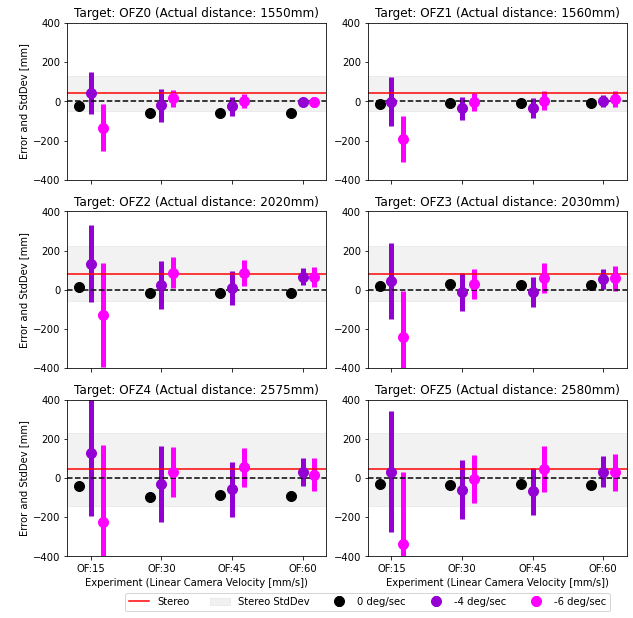

In [26]:
fig, ax = plt.subplots(3,2, figsize=(8.5,8))
plt.tight_layout()
for ind, target in enumerate(actual_dist.index):
    ind_y = int(ind/2)
    ind_x = int(ind%2)
    
    y_0 = error_ofd_0.loc[target].values
    e_0 = std_ofd_0.loc[target].values

    y_2 = error_ofd_2.loc[target].values
    e_2 = std_ofd_2.loc[target].values

    y_4 = error_ofd_4.loc[target].values
    e_4 = std_ofd_4.loc[target].values

    y_6 = error_ofd_6.loc[target].values
    e_6 = std_ofd_6.loc[target].values


    ax[ind_y, ind_x].set_title('Target: {} (Actual distance: {}mm)'.format(target, int(actual_dist[target])))
    ax[ind_y, ind_x].axhline(y=0, xmin=0, xmax=1, color='k', linestyle='--')
    # The red line for the stereo results
    stereo = ax[ind_y, ind_x].axhline(y=stereo_err[target], xmin=0, xmax=1, 
                       color='red', linestyle='-')
    


    stereo_var = ax[ind_y, ind_x].axhspan(stereo_err[target]-stereo_std[target],
                       stereo_err[target]+stereo_std[target],
                       xmin=0, xmax=1, color='grey', alpha=0.10)
    if ind_x == 0:
        ax[ind_y, ind_x].set_ylabel('  \nError and StdDev [mm]')
    # 0 deg/s    
    r_0 = ax[ind_y, ind_x].errorbar(x_pos-.166, y_0, e_0, linestyle='None', color='k', marker='o',markersize=10, 
                        ecolor='k', elinewidth=5, label='0 deg/s')
    # 2 deg/s    
#    ax[ind_y, ind_x].errorbar(x_pos+.166, y_2, e_2, linestyle='None', color='mediumblue', marker='o',markersize=10, 
#                        ecolor='mediumblue', elinewidth=5, label='-2 deg/s')
    # 4 deg/s    
    r_4 = ax[ind_y, ind_x].errorbar(x_pos, y_4, e_4, linestyle='None', color='darkviolet', marker='o',markersize=10, 
                        ecolor='darkviolet', elinewidth=5, label='-4 deg/s')

    # 6 deg/s    
    r_6 = ax[ind_y, ind_x].errorbar(x_pos+.166, y_6, e_6, linestyle='None', color='fuchsia', marker='o',markersize=10, 
                        ecolor='fuchsia', elinewidth=5, label='-6 deg/s')


    ax[ind_y, ind_x].set_ylim([-400,400])

    
    if ind_y == 2:
        
        ax[ind_y, ind_x].set_xlabel('Experiment (Linear Camera Velocity [mm/s])')
        ax[ind_y, ind_x].set_xticks(x_pos)
        ax[ind_y, ind_x].set_xticklabels(x)
    else:
        ax[ind_y, ind_x].set_xticks(x_pos)
        ax[ind_y, ind_x].set_xticklabels([])
        a=1
        
    
#handles, labels = ax[0,0].get_legend_handles_labels()
#ax[0,0].legend((stereo, stereo_var, r_0, r_4, r_6), ('Stereo', 'Stereo StdDev','0 deg/sec', '-4 deg/sec', '-6 deg/sec'), loc='upper left')
plt.legend((stereo, stereo_var, r_0, r_4, r_6), 
           ('Stereo', 'Stereo StdDev','0 deg/sec', '-4 deg/sec', '-6 deg/sec'),
           loc='upper center', bbox_to_anchor=(0, -0.2),
          fancybox=True, ncol=5)

plt.savefig('{}error and std dev.png'.format(datadir),dpi=300, bbox_inches = "tight", ) 
plt.show()

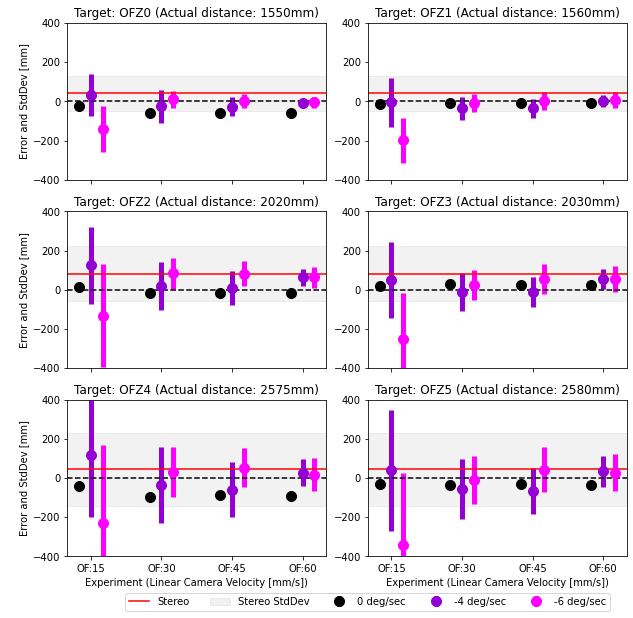

In [256]:
fig, ax = plt.subplots(3,2, figsize=(8.5,8))
plt.tight_layout()
for ind, target in enumerate(actual_dist.index):
    ind_y = int(ind/2)
    ind_x = int(ind%2)
    
    y_0 = error_ofd_0.loc[target].values
    e_0 = std_ofd_0.loc[target].values

    y_2 = error_ofd_2.loc[target].values
    e_2 = std_ofd_2.loc[target].values

    y_4 = error_ofd_4.loc[target].values
    e_4 = std_ofd_4.loc[target].values

    y_6 = error_ofd_6.loc[target].values
    e_6 = std_ofd_6.loc[target].values


    ax[ind_y, ind_x].set_title('Target: {} (Actual distance: {}mm)'.format(target, int(actual_dist[target])))
    ax[ind_y, ind_x].axhline(y=0, xmin=0, xmax=1, color='k', linestyle='--')
    # The red line for the stereo results
    stereo = ax[ind_y, ind_x].axhline(y=stereo_err[target], xmin=0, xmax=1, 
                       color='red', linestyle='-')
    


    stereo_var = ax[ind_y, ind_x].axhspan(stereo_err[target]-stereo_std[target],
                       stereo_err[target]+stereo_std[target],
                       xmin=0, xmax=1, color='grey', alpha=0.10)
    if ind_x == 0:
        ax[ind_y, ind_x].set_ylabel('  \nError and StdDev [mm]')
    # 0 deg/s    
    r_0 = ax[ind_y, ind_x].errorbar(x_pos-.166, y_0, e_0, linestyle='None', color='k', marker='o',markersize=10, 
                        ecolor='k', elinewidth=5, label='0 deg/s')
    # 2 deg/s    
#    ax[ind_y, ind_x].errorbar(x_pos+.166, y_2, e_2, linestyle='None', color='mediumblue', marker='o',markersize=10, 
#                        ecolor='mediumblue', elinewidth=5, label='-2 deg/s')
    # 4 deg/s    
    r_4 = ax[ind_y, ind_x].errorbar(x_pos, y_4, e_4, linestyle='None', color='darkviolet', marker='o',markersize=10, 
                        ecolor='darkviolet', elinewidth=5, label='-4 deg/s')

    # 6 deg/s    
    r_6 = ax[ind_y, ind_x].errorbar(x_pos+.166, y_6, e_6, linestyle='None', color='fuchsia', marker='o',markersize=10, 
                        ecolor='fuchsia', elinewidth=5, label='-6 deg/s')


    ax[ind_y, ind_x].set_ylim([-400,400])

    
    if ind_y == 2:
        
        ax[ind_y, ind_x].set_xlabel('Experiment (Linear Camera Velocity [mm/s])')
        ax[ind_y, ind_x].set_xticks(x_pos)
        ax[ind_y, ind_x].set_xticklabels(x)
    else:
        ax[ind_y, ind_x].set_xticks(x_pos)
        ax[ind_y, ind_x].set_xticklabels([])
        a=1
        
    
#handles, labels = ax[0,0].get_legend_handles_labels()
#ax[0,0].legend((stereo, stereo_var, r_0, r_4, r_6), ('Stereo', 'Stereo StdDev','0 deg/sec', '-4 deg/sec', '-6 deg/sec'), loc='upper left')
plt.legend((stereo, stereo_var, r_0, r_4, r_6), 
           ('Stereo', 'Stereo StdDev','0 deg/sec', '-4 deg/sec', '-6 deg/sec'),
           loc='upper center', bbox_to_anchor=(0, -0.2),
          fancybox=True, ncol=5)

plt.savefig('{}error and std dev.png'.format(datadir),dpi=300, bbox_inches = "tight", ) 
plt.show()